In [102]:
#data manipulation
import pandas as pd
import numpy as np
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
#graphs
import seaborn as sns
import matplotlib.pyplot as plt
#classificadores
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#metricas
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, average_precision_score, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('Datasets/train.csv', sep='|')

### Undersampling before cross validate
- prone to overfitting

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: fraud, dtype: float64


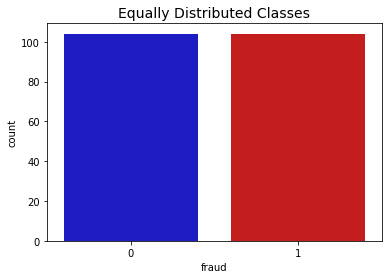

In [3]:
train = train.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = train.loc[train['fraud'] == 1]
non_fraud_df = train.loc[train['fraud'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42).reset_index(drop=True)
print('Distribution of the Classes in the subsample dataset')
print(new_df['fraud'].value_counts()/len(new_df))
colors = ["#0101DF", "#DF0101"]
sns.countplot('fraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [4]:
X = new_df.drop('fraud', 1)
Y = new_df['fraud']

def Standardization(data):
    data = (data - data.mean()) / data.std()
    data = data.fillna(data.mean())
    return data
#padronizando X
X = Standardization(X)
X_scaled = pd.DataFrame(RobustScaler().fit_transform(X))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=3)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 89.0 % accuracy score
Classifiers:  LGBMClassifier Has a training score of 92.0 % accuracy score


In [6]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
lgbm_params = {'learning_rate': [0.005],'n_estimators': [40],'colsample_bytree' : [0.65, 0.66], 'subsample' : [0.7,0.75],
               'reg_alpha' : [1,1.2],'reg_lambda' : [1,1.2,1.4]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
#get the best estimator
log_reg = grid_log_reg.best_estimator_

grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

grid_lgbm = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm.fit(X_train, y_train)

# lgbm best estimator
lgbm = grid_lgbm.best_estimator_

In [7]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=3)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=3)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

lgbm_score = cross_val_score(lgbm, X_train, y_train, cv=3)
print('LGBM Classifier Cross Validation Score', round(lgbm_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  95.15%
Support Vector Classifier Cross Validation Score 94.56%
LGBM Classifier Cross Validation Score 86.16%


### undersample during cross validating

In [80]:
splits = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

Xtrain = train.drop('fraud', axis=1)
Ytrain = train['fraud']
Xtrain = pd.DataFrame(RobustScaler().fit_transform(Xtrain))

#Mantendo cópia original para teste
for train_index, test_index in splits.split(Xtrain, Ytrain):
    original_Xtrain, original_Xtest = Xtrain.iloc[train_index], Xtrain.iloc[test_index]
    original_ytrain, original_ytest = Ytrain.iloc[train_index], Ytrain.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [81]:
undersample_X = train.drop('fraud', axis=1)
undersample_y = train['fraud']
undersample_X = pd.DataFrame(RobustScaler().fit_transform(undersample_X))

for train_index, test_index in splits.split(undersample_X, undersample_y):
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

c = 0
for training, testing in splits.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[training], undersample_ytrain[training])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[testing])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[testing], original_ytrain[testing]))
    undersample_precision.append(precision_score(original_ytrain[testing], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[testing], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[testing], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[testing], undersample_prediction))
    

In [82]:
#Function to plot learning curves by: janiobachmann(Kaggle Kernels) [MODIFIED]

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Suport Vector Classifier", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("LGBMClassifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\oieus\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

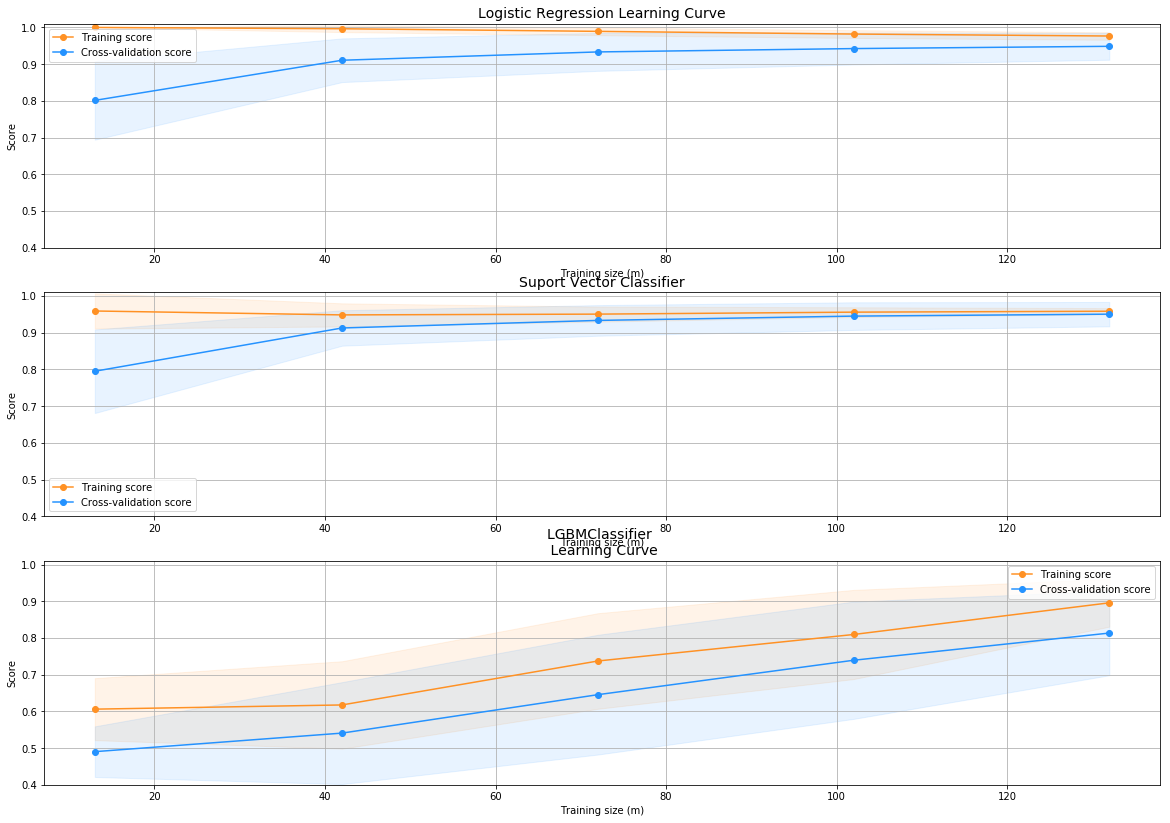

In [83]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, svc, lgbm, X_train, y_train, (0.4, 1.01), cv=cv, n_jobs=4)

### Curva ROC

In [84]:
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=3,
                             method="decision_function")
svc_pred = cross_val_predict(svc, X_train, y_train, cv=3,
                             method="decision_function")
lgbm_pred = cross_val_predict(lgbm, X_train, y_train, cv=3)

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('LGBM Classifier: ', roc_auc_score(y_train, lgbm_pred))

Logistic Regression:  0.9724037763253449
Support Vector Classifier:  0.9671750181554104
LGBM Classifier:  0.8615105301379812


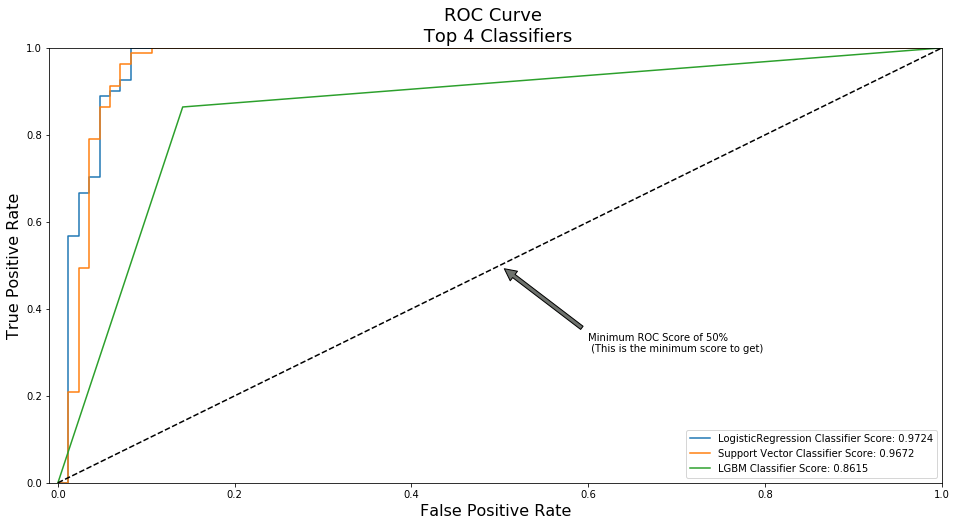

In [85]:
#Function to plot ROC curve by: janiobachmann(Kaggle Kernels) [MODIFIED]

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
lgbm_fpr, lgbm_tpr, lgbm_threshold = roc_curve(y_train, lgbm_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, lgbm_fpr, lgbm_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='LogisticRegression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(lgbm_fpr, lgbm_tpr, label='LGBM Classifier Score: {:.4f}'.format(roc_auc_score(y_train, lgbm_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, lgbm_fpr, lgbm_tpr)
plt.show()

In [89]:
matrix = confusion_matrix(y_train, lgbm_pred)
weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-5,-25,5]))
print(f"Score Cup: {weightSum}")
print(matrix)

y_pred_lgbm = lgbm.predict(X_test)
matrix2 = confusion_matrix(y_test, y_pred_lgbm)
weightSum2 = np.sum(np.reshape(matrix2, 4)*np.array([0,-5,-25,5]))
print(f"Score Cup: {weightSum2}")
print(matrix2)


Score Cup: 15
[[73 12]
 [11 70]]
Score Cup: 75
[[17  2]
 [ 1 22]]


In [88]:
matrix = confusion_matrix(y_train, cross_val_predict(log_reg, X_train, y_train, cv=5))
weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-5,-25,5]))
print(f"Score Cup: {weightSum}")
print(matrix)

y_pred_lr = log_reg.predict(X_test)
matrix2 = confusion_matrix(y_test, y_pred_lr)
weightSum2 = np.sum(np.reshape(matrix2, 4)*np.array([0,-5,-25,5]))
print(f"Score Cup: {weightSum2}")
print(matrix2)

Score Cup: 370
[[78  7]
 [ 0 81]]
Score Cup: -490
[[18  1]
 [20  3]]


In [90]:
matrix = confusion_matrix(y_train, cross_val_predict(svc, X_train, y_train, cv=5))
weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-5,-25,5]))
print(f"Score Cup train: {weightSum}")
print(matrix)

y_pred_svc = svc.predict(X_test)
matrix2 = confusion_matrix(y_test, y_pred_svc)
weightSum2 = np.sum(np.reshape(matrix2, 4)*np.array([0,-5,-25,5]))
print(f"Score Cup validation: {weightSum2}")
print(matrix2)

Score Cup train: 360
[[76  9]
 [ 0 81]]
Score Cup validation: 105
[[17  2]
 [ 0 23]]


In [77]:
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.01
Precision Score: 0.50
F1 Score: 0.02
Accuracy Score: 0.51
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.90
Precision Score: 0.37
Recall Score: 0.94
F1 Score: 0.53
---------------------------------------------------------------------------------------------------------------------------------------


### Oversampling - SMOTE

In [138]:

def BestModelSMOTE(model, params, decfunc=True):
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    rand_model = RandomizedSearchCV(model, params, n_iter=10)

    for train, test in splits.split(original_Xtrain, original_ytrain):
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_model) # SMOTE happens during Cross Validation not before..
        model_pipe = pipeline.fit(original_Xtrain[train], original_ytrain[train])
        best_est = rand_model.best_estimator_
        prediction = best_est.predict(original_Xtrain[test])

        accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
        precision_lst.append(precision_score(original_ytrain[test], prediction))
        recall_lst.append(recall_score(original_ytrain[test], prediction))
        f1_lst.append(f1_score(original_ytrain[test], prediction))
        auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    metrics = pd.DataFrame()
    metrics['accuracy'] = pd.Series(np.mean(accuracy_lst))
    metrics['precision'] = pd.Series(np.mean(precision_lst))
    metrics['recall'] = pd.Series(np.mean(recall_lst))
    metrics['F1'] = pd.Series(np.mean(f1_lst))
    labels = ['No Fraud', 'Fraud']
    smote_prediction = best_est.predict(original_Xtest)
    classification = classification_report(original_ytest, smote_prediction, target_names=labels)
    np.sum(np.reshape(confusion_matrix(original_ytest, smote_prediction), 4)*np.array([0,-5,-25,5]))
    confusion_matrix(original_ytest, smote_prediction)
    if decfunc:
        y_score = best_est.decision_function(original_Xtest)
    else:
        y_score = best_est.predict(original_Xtest)
    metrics['avg_precision-recall'] = average_precision_score(original_ytest, y_score)
    fig = plt.figure(figsize=(12,6))
    
    precision, recall, _ = precision_recall_curve(original_ytest, y_score)

    plt.step(recall, precision, color='r', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='#F59B00')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
              average_precision), fontsize=16)
    return best_est, metrics, classification

              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.99       355
       Fraud       0.69      0.95      0.80        21

   micro avg       0.97      0.97      0.97       376
   macro avg       0.84      0.96      0.89       376
weighted avg       0.98      0.97      0.98       376



accuracy  precision    recall        F1  avg_precision-recall
0  0.966777   0.650127  0.929412  0.763121              0.931117

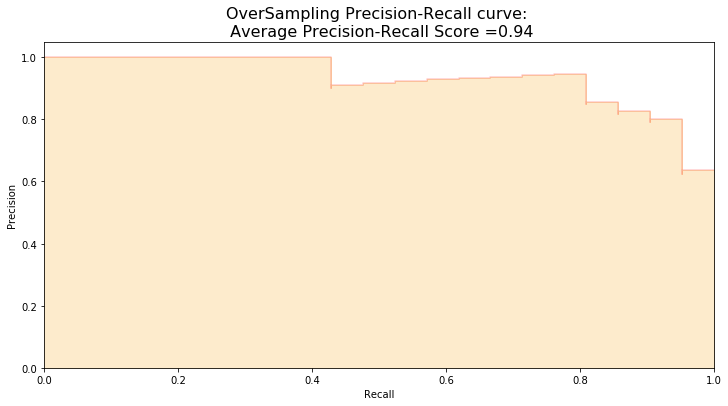

In [140]:
lr = LogisticRegression()
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
best_lr, metrics, classification = BestModelSMOTE(lr, log_reg_params, True)
print(classification)
metrics.head()

              precision    recall  f1-score   support

    No Fraud       1.00      0.96      0.98       355
       Fraud       0.60      1.00      0.75        21

   micro avg       0.96      0.96      0.96       376
   macro avg       0.80      0.98      0.86       376
weighted avg       0.98      0.96      0.97       376



accuracy  precision    recall        F1  avg_precision-recall
0  0.943522   0.502951  0.976471  0.663108              0.939623

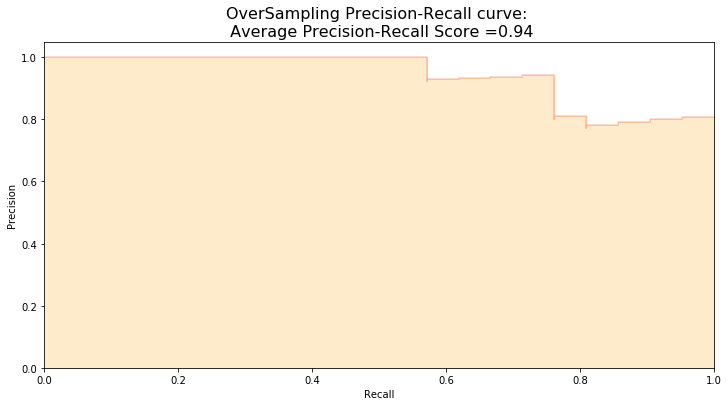

In [141]:
svc = SVC()

svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
best_svc, metrics, classification = BestModelSMOTE(svc, svc_params, True)
print(classification)
metrics.head()

              precision    recall  f1-score   support

    No Fraud       0.99      0.96      0.97       355
       Fraud       0.53      0.81      0.64        21

   micro avg       0.95      0.95      0.95       376
   macro avg       0.76      0.88      0.81       376
weighted avg       0.96      0.95      0.95       376



accuracy  precision    recall        F1  avg_precision-recall
0  0.957475   0.599903  0.776471  0.674093              0.440698

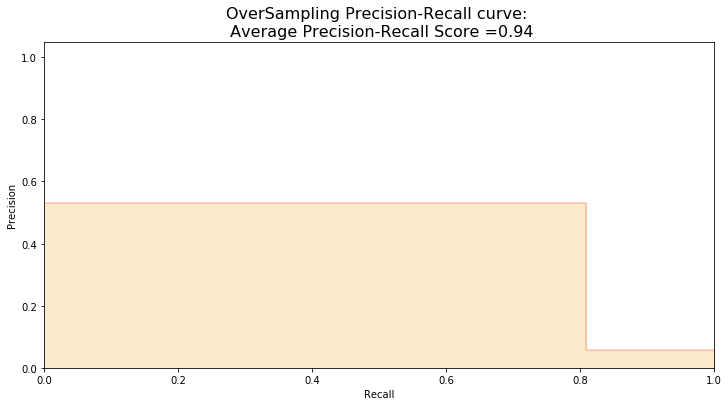

In [142]:
lgbm = LGBMClassifier()

lgbm_params = {'learning_rate': [0.005],'n_estimators': [40],'colsample_bytree' : [0.65, 0.66], 'subsample' : [0.7,0.75],
               'reg_alpha' : [1,1.2],'reg_lambda' : [1,1.2,1.4]}
best_, metrics, classification = BestModelSMOTE(lgbm, lgbm_params, False)
print(classification)
metrics.head()

In [150]:
y_pred_svc = best_svc.predict(original_Xtest)
print(f"Score Cup: {np.sum(np.reshape(confusion_matrix(original_ytest, y_pred_svc), 4)*np.array([0,-5,-25,5]))}")
print(confusion_matrix(original_ytest, y_pred_svc))
print(f"AUC: {roc_auc_score(original_ytest, y_pred_svc)}")

Score Cup: 35
[[341  14]
 [  0  21]]
AUC: 0.9802816901408451


In [151]:
y_pred_lr = best_lr.predict(original_Xtest)
print(f"Score Cup: {np.sum(np.reshape(confusion_matrix(original_ytest, y_pred_lr), 4)*np.array([0,-5,-25,5]))}")
print(confusion_matrix(original_ytest, y_pred_lr))
print(f"AUC: {roc_auc_score(original_ytest, y_pred_lr)}")

Score Cup: 30
[[346   9]
 [  1  20]]
AUC: 0.963514419852448
